In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string
import warnings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel, TransfoXLTokenizer, TransfoXLModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Input, Dropout,Add, Activation, Dense, Lambda, Flatten, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning import Trainer
import torch
from tcn import TCN

warnings.filterwarnings('ignore')

In [68]:
data = pd.read_csv('ghg-emissions2.csv')
data = data[:-2]
print(data.head(10))

   iso Country/Region    unit  1850  1851  1852  1853  1854  1855  1856  ...  \
0  BGD     Bangladesh  MtCO2e  21.5  21.7  22.0  22.2  22.4  22.6  22.8  ...   

    2010   2011   2012   2013   2014   2015   2016   2017   2018   2019  
0  139.0  144.0  150.0  152.0  158.0  168.0  171.0  179.0  188.0  201.0  

[1 rows x 173 columns]


In [69]:
bangladesh_data = data[data['iso'] == 'BGD']
bangladesh_data = bangladesh_data.drop(columns=['iso', 'Country/Region', 'unit'])

# Transpose the data to have years as rows
bangladesh_data = bangladesh_data.T
bangladesh_data.columns = ['GHG_Emissions']
bangladesh_data.index.name = 'Year'

# Convert the index to integers
bangladesh_data.index = bangladesh_data.index.astype(int)
bangladesh_data.tail(5)

,GHG_Emissions
Year,
2015,168.0
2016,171.0
2017,179.0
2018,188.0
2019,201.0


In [70]:
# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(bangladesh_data)

In [71]:
window_size = 5
X = []
y = []

for i in range(window_size, len(normalized_data)):
    X.append(normalized_data[i-window_size:i, 0])
    y.append(normalized_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

In [72]:
# Split data into training and testing sets
train_size = int(len(X) * 0.82)
# train_size = int(len(X) * 0.94)
# train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## TCN

In [13]:
# TCN model
def build_model(input_shape, num_filters=64, kernel_size=3, dropout_rate=0.3):
    model = Sequential()

    #TCN
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='causal', activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='causal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='causal', activation='relu'))
    model.add(Dropout(dropout_rate))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [7]:
def build_tcn_model(input_shape, dropout_rate=0.3):
    model = Sequential()

    # Define input layer
    model.add(Input(shape=input_shape))

    # TCN Layer

    model.add(TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = 'relu'))
    model.add(TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = 'relu'))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Assuming X_train is your training data
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_tcn_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 5, 128)            247168    
                                                                 
 tcn_1 (TCN)                 (None, 5, 64)             94656     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 50)                16050     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 357,925
Trainable params: 357,925
Non-trainable params: 0
_________________________________________________________________


## CNN

In [10]:
# CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

## CNN-LSTM

In [7]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

## LSTM

In [35]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [8]:
# # Define early stopping and model checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [17]:
# Define WaveNet residual block
def residual_block(x, dilation_rate):
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal')(r)
    r = Add()([x, r])
    r = Activation('relu')(r)
    return r

# Define the hybrid WaveNet-TCN model
input_layer = Input(shape=(X_train.shape[1], 1))

# Add WaveNet residual blocks
wavenet_layer = residual_block(input_layer, 1)
wavenet_layer = residual_block(wavenet_layer, 2)
wavenet_layer = residual_block(wavenet_layer, 4)

# Add TCN layers
tcn_layer = TCN(128, dilations=[1, 2, 4], activation='relu', return_sequences=True)(wavenet_layer)
tcn_layer = TCN(64, dilations=[1, 2, 4], activation='relu', return_sequences=False)(tcn_layer)

# Add Dense layers
dense_layer_1 = Dense(64, activation='relu')(tcn_layer)
output_layer = Dense(1)(dense_layer_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [26]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
5/5 [==============================] - 0s 16ms/step - loss: 9.4257e-05 - val_loss: 0.0233
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0638e-04 - val_loss: 0.0253
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 9.4438e-05 - val_loss: 0.0274
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 8.7324e-05 - val_loss: 0.0235
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 8.3891e-05 - val_loss: 0.0268
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 8.6061e-05 - val_loss: 0.0271
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0108e-04 - val_loss: 0.0251
Epoch 8/50
5/5 [==============================] - 0s 11ms/step - loss: 1.2228e-04 - val_loss: 0.0264
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 9.4812e-05 - val_loss: 0.0245
Epoch 10/50
5/5 [==============================] - 0s 12ms/step - loss: 8.8663e-05 - val_lo

In [27]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 16ms/step


In [28]:
# Adjust the index ranges to match predictions and actual emissions
actual_emissions = bangladesh_data.loc[1990:2019, 'GHG_Emissions'].values
predicted_emissions_start_year = 1990 + (len(bangladesh_data) - len(predictions) - window_size)

predicted_emissions = bangladesh_data.iloc[predicted_emissions_start_year:1990].values.flatten()
predicted_emissions = np.concatenate([predicted_emissions, predictions.flatten()])
predicted_emissions = predicted_emissions[:len(actual_emissions)]

In [29]:
# Calculate performance metrics
mae = mean_absolute_error(actual_emissions, predicted_emissions)
mse = mean_squared_error(actual_emissions, predicted_emissions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_emissions, predicted_emissions)
r2 = r2_score(actual_emissions, predicted_emissions)
max_err = max_error(actual_emissions, predicted_emissions)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('R² Score:', r2)
print('Max Error:', max_err)

Mean Absolute Error (MAE): 22.655567016601562
Mean Squared Error (MSE): 1208.3767646212368
Root Mean Squared Error (RMSE): 34.76171406333751
Mean Absolute Percentage Error (MAPE): 0.14811517326467408
R² Score: 0.34152266350962923
Max Error: 85.0853271484375


In [ ]:
# Define the metrics and their values
metrics = ['MAE', 'MSE', 'RMSE', 'MAPE', 'R² Score', 'Max Error']
values = [mae, mse, rmse, mape, r2, max_err]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])
plt.xlabel('Performance Metrics')
plt.ylabel('Metric Values')
plt.title('Performance Metrics of the Hybrid WaveNet-TCN Model')
plt.ylim([0, max(values) + 10])  # Adjust ylim for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the graph
plt.show()

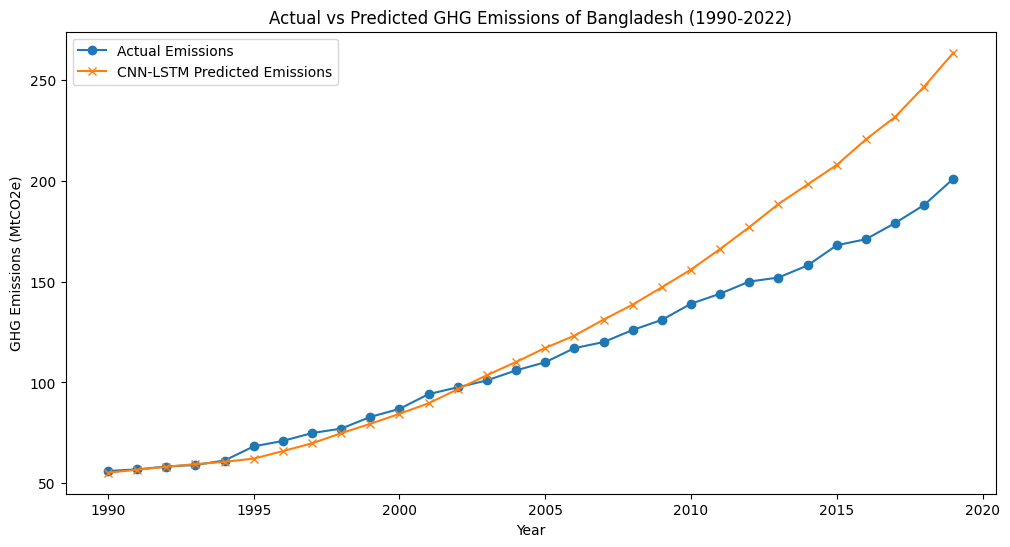

In [21]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(1990, 2020), actual_emissions, label='Actual Emissions', marker='o')
plt.plot(range(1990, 2020), predicted_emissions, label='CNN-LSTM Predicted Emissions', marker='x')
plt.xlabel('Year')
plt.ylabel('GHG Emissions (MtCO2e)')
plt.title('Actual vs Predicted GHG Emissions of Bangladesh (1990-2022)')
plt.legend()
plt.show()

# Next 10 years

In [5]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(normalized_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for TCN
X = X.reshape(X.shape[0], X.shape[1], 1)

# CNN

In [56]:
# Create the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# LSTM

In [50]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# CNN-LSTM

In [17]:
# Create the CNN-LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# wavenet

In [6]:
# Define WaveNet residual block
def residual_block(x, dilation_rate):
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal')(r)
    r = Add()([x, r])
    r = Activation('relu')(r)
    return r

# Define the hybrid WaveNet-TCN model
input_layer = Input(shape=(time_step, 1))

# Add WaveNet residual blocks
wavenet_layer = residual_block(input_layer, 1)
wavenet_layer = residual_block(wavenet_layer, 2)
wavenet_layer = residual_block(wavenet_layer, 4)

# Add TCN layer
tcn_layer = TCN(128, dilations=[1, 2, 4], activation='relu', return_sequences=True)(wavenet_layer)
tcn_layer = TCN(64, dilations=[1, 2, 4], activation='relu', return_sequences=False)(tcn_layer)

# Add Dense layers
dense_layer_1 = Dense(64, activation='relu')(tcn_layer)
output_layer = Dense(1)(dense_layer_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
# Train the model
model.fit(X, y, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
10/10 [==============================] - 0s 3ms/step - loss: 1.2632e-04
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 1.2460e-04
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 1.1846e-04
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 1.1260e-04
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 1.1834e-04
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 1.1884e-04
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 1.0830e-04
Epoch 8/50
10/10 [==============================] - 0s 2ms/step - loss: 1.1767e-04
Epoch 9/50
10/10 [==============================] - 0s 2ms/step - loss: 1.1008e-04
Epoch 10/50
10/10 [==============================] - 0s 2ms/step - loss: 1.0676e-04
Epoch 11/50
10/10 [==============================] - 0s 2ms/step - loss: 1.0860e-04
Epoch 12/50
10/10 [==============================] - 0s 2ms/step - loss: 1.0857e-04
E

In [63]:
# Make predictions for the next 10 years (2020-2030)
predictions = []
input_seq = normalized_data[-time_step:].reshape(1, time_step, 1)

for _ in range(11):
    next_pred = model.predict(input_seq)
    predictions.append(next_pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions
predicted_emissions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print(predicted_emissions.flatten().tolist())

1/1 [==============================] - 0s 15ms/step
[201.59423828125, 209.44508361816406, 218.01280212402344, 226.3288116455078, 233.8983612060547, 242.8125762939453, 251.5909423828125, 260.831787109375, 269.8047790527344, 279.4702453613281, 289.1580810546875]


In [64]:
# Print the predictions for the years 2020-2030
years = list(range(2020, 2031))
predicted_values = predicted_emissions.flatten().tolist()

# Print table header
print(f"{'Year':<6} {'Predicted GHG Emissions (MtCO2e)':<30}")
print("-" * 36)

# Print each year and corresponding prediction
for year, value in zip(years, predicted_values):
    print(f"{year:<6} {value:<30.2f}")

Year   Predicted GHG Emissions (MtCO2e)
------------------------------------
2020   201.59                        
2021   209.45                        
2022   218.01                        
2023   226.33                        
2024   233.90                        
2025   242.81                        
2026   251.59                        
2027   260.83                        
2028   269.80                        
2029   279.47                        
2030   289.16                        


In [65]:
# Create a DataFrame for actual and predicted emissions
actual_emissions = bangladesh_data['GHG_Emissions'].values
years = np.arange(1850, 2020)

predicted_years = np.arange(2020, 2031)
predicted_emissions_df = pd.DataFrame(data=predicted_emissions, index=predicted_years, columns=['Predicted_GHG_Emissions'])


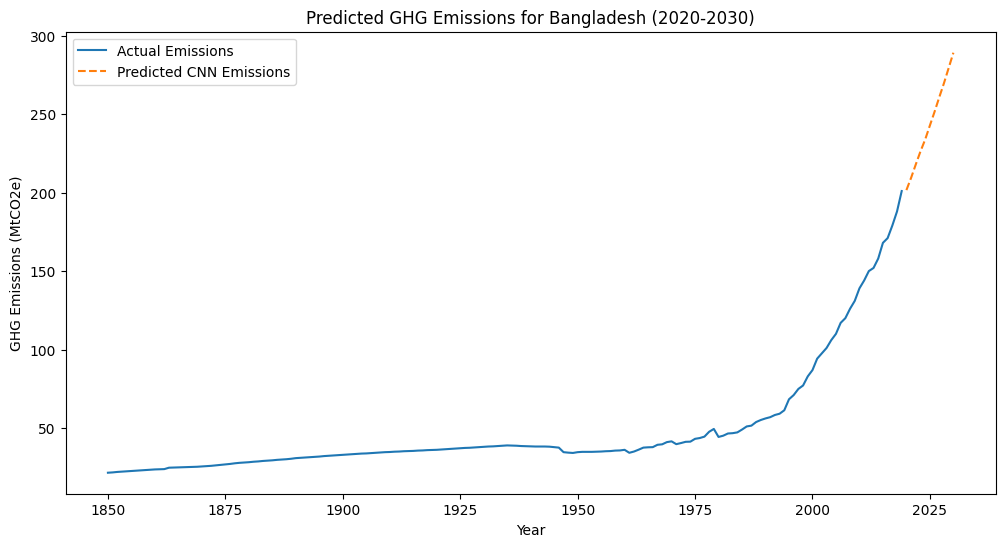

In [66]:
# Plot the actual vs. predicted emissions
plt.figure(figsize=(12, 6))
plt.plot(years, actual_emissions, label='Actual Emissions')
plt.plot(predicted_years, predicted_emissions_df['Predicted_GHG_Emissions'], label='Predicted CNN Emissions', linestyle='--')
plt.xlabel('Year')
plt.ylabel('GHG Emissions (MtCO2e)')
plt.title('Predicted GHG Emissions for Bangladesh (2020-2030)')
plt.legend()
plt.show()